# Example: Dynamic Delta Neutral Hedging to Compensate for Price Fluctuations
[Delta hedging](https://en.wikipedia.org/wiki/Delta_neutral) is a strategy used in options trading to minimize the risk associated with price movements in the underlying asset. This approach involves using other options contracts or shares of the underlying asset to achieve a delta-neutral position, i.e., eliminating the position's directional bias.
* __Scenario__: Now, put yourself in the shoes of a trader. You've purchased a `TSLA` put option and are now short the shares. You're concerned about how the price movement of `TSLA` shares could affect your options position. This is where you need to take action and construct a delta-neutral hedge to manage this risk.

From the buyer's perspective, by purchasing a put option, the buyer believes that `TSLA` shares will decline in price, i.e., the buyer is `bearish` on `TSLA.` Let's explore how delta-neutral hedging would work for a long put.

## Learning objectives
This example is designed to familiarize students with computing a hedged position on a `TSLA` put option. It assumes perfect information and no market friction, i.e., no problems with buying or selling the `TSLA` shares and no transaction costs. By the end, you will have a clear understanding of this complex strategy.

* __Prerequisites__: We'll begin by setting some constant values, load various datasets that we use later, and compute values used to simulate future share prices and implied volatility values.
* __Task 1__: Generate synthetic future market state trajectories. In this task, we will generate a family of future price and volatility trajectories for `TSLA.`
    * `TODO`: Sample Discrete Binomial Equity Tree of Future Share Prices
    * `TODO`: Sample Synthetic Future Implied Volatility Trajectories
* __Task 2__: Construct a dynamically hedged position on a `TSLA` put. In this task, we'll dynamically compute the number of shares in the hedged position that are required to exactly maintain the value of the position.
    * `TODO`: Build a put contract model
    * `TODO`: Compute the Greek values for the sample TSLA put option
    * `TODO`: Simulate a Dynamic Equity Hedge assuming perfect information and no market friction

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites
Before we set up the [hedge](https://www.investopedia.com/terms/d/deltahedging.asp) on the `TSLA` put option, let's first define some constants we'll use later. This includes details about the contract and parameters controlling the simulation. After that, we'll proceed to load data for `TSLA` put contracts to explore. Lastly, we'll load price and volatility data for TSLA, which we'll use to build a share price and volatility projection. Please review this section before moving on to the tasks below, and make sure you understand the various variables and datasets loaded here, as they will be important later on.

### Constants
- First, we need to set up details regarding the options contracts we are exploring. The variable `DTE::Float64` represents the days to the expiration of the options contracts (measured in days), `Δt::Float64` represents the time step used in the simulations. In this case, we are using 1-minute aggregate data (measured in years). The variable `number_of_trading_periods::Int64` represents the number of trading periods we explore, i.e., the number of minutes that we want to simulate, and `T::Float64` denotes the length of the options contracts (measured in years).
- Next, we define information about `TSLA` and the parameters for the binomial lattice used in the simulation. The variable `β::Float64` represents the beta value for `TSLA`, `h::Int64` represents the number of levels of the pricing tree, the variable `risk_free_rate::Float64` represents the risk-free rate (in this case assumed to be the yield on a 10-year US Treasury Note), the variable `number_of_samples::Int64` specifies the number of samples (alternative futures) we will generate in the simulation, and finally, `sample_synthetic_index::Int64` is a randomly chosen index which specifies which sample we'll use in the simulation.

In [6]:
DTE = 60.5; # data from mid-day, add a little something something so we recover the midpoint premium (ish) (all parameters fixed)
Δt = (1/390)*(1/252); # 1-min trading periods
number_of_trading_periods = 120; # How many trading periods will we simulate?
T = (DTE)*(1/365); # Duration of trading periods in option years
β = 2.32; # TSLA 5y monthly beta value 06-25-24
h = 366; # 6-points per trading period
risk_free_rate = 0.0431; # yield 10-year treasury note on 13-Jun-2024
number_of_samples = 1000; # number of samples to generate
sample_synthetic_index = rand(1:number_of_samples); # generate random synthetic index to explore (must be <= number_of_samples)

### Contracts
In this example, we'll use data for `TSLA` contracts from approximately 60 days to expiration. First, we load the data stored as a file in the [HDF5 data format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format#:~:text=HDF5%20simplifies%20the%20file%20structure,hold%20datasets%20and%20other%20group), using the [load method from the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). The [load function](https://juliaio.github.io/JLD2.jl/dev/#save-and-load-functions) returns a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) holding the contract data in the `data` key (we can access by passing the key to the dictionary instance). We store the contract information in the `all_options_dataset::Vector{Dict{String, Any}}` variable, a vector of dictionaries holding information for put and call contracts:

In [8]:
all_options_dataset = load(joinpath(_PATH_TO_DATA, "TSLA-today-2023-06-19-exp-2023-08-18-dte-60d.jld2")) |> dict -> dict["data"];

Since we are interested in only put contracts, let's filter out the call contracts and build a `put_contract_dataset::Vector{Dict{String, Any}}` data structure holding the put contract information using a `for-loop.`
* First, we initialize storage to hold the put contracts in the `put_contract_dataset::Array{Dict{String, Any},1}` array. Next, we iterate through each contract in the `all_options_dataset` using the [Julia eachindex iteration pattern](https://docs.julialang.org/en/v1/base/arrays/#Base.eachindex). On `Line 3`, we access contract `i` from the `all_options_dataset` (stored as the `contract` variable). Then, on `Line 4`, we check if `contract` is a call or put. If `contract` is a put, we store it in the `put_contract_dataset` using the [Julia `push!()` method for adding items to an array](https://docs.julialang.org/en/v1/base/collections/#Base.push!).
* We've added some additional logic (encoded as a second clause using the [Julia `&&` short-circuit operator which encodes the logical AND operation](https://docs.julialang.org/en/v1/manual/control-flow/#Short-Circuit-Evaluation)) to the `if` statement on `Line 4.` The second clause checks the contract strike price, and removes contracts that are outside of a strike price range, i.e., we want contracts with strikes
$K\in\left[K_{\text{min}},\,K_{\text{max}}\right]$ where you specify the minimum strike $K_{\text{min}}$ and the maximum strike $K_{\text{max}}$.

In [10]:
put_contract_dataset = Array{Dict{String,Any},1}();
for i ∈ eachindex(all_options_dataset)
    contract = all_options_dataset[i];
    if (contract["details"]["contract_type"] == "put" && 
            (200 ≤ contract["details"]["strike_price"] && contract["details"]["strike_price"] ≤ 300)) # filter on strike price
        push!(put_contract_dataset, contract) # store put contract
    end
end

#### Choose a contract instance
There are many put options contracts to choose from, and you can choose whichever contract instance you want, but we'll explore a put that is close to the money, i.e., $K\sim{S}_{o}$ (the strike is close to the current share price). We choose the contract at `index = 9` and store the contract data in the `example_put_contract::Dict{String, Any}` variable.

In [12]:
example_put_contract = put_contract_dataset[9]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>25.03, "change…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>23.7, "ask"=>23.8, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.198501, "gamma"=>0.0063…
  "open_interest"      => 2878
  "implied_volatility" => 0.605621
  "break_even_price"   => 236.3

Finally, we set some data from this contract, in particular, the initial share price in the `Sₒ::Float64` variable and the implied volatility `IVₒ::Float64` variable:

In [14]:
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE

### Share price and volatility data
We compute potential future share prices using a [data-driven binomial lattice model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#Lattice-Models), which requires values for the up-factor `u,` the down-factor `d,` and the probability of an up move `p` in a single trading period. We estimate the expected `u, d,` and `p` factors using `1-minute` aggregate price data collected for `2023`; the `TSLA` data was downloaded from [oneminutedata.com](https://oneminutedata.com). 
* The `TSLA` dataset, which is stored as a [comma-separated value (CSV) file](https://en.wikipedia.org/wiki/Comma-separated_values), is loaded using the [read method exported by the CSV.jl package](https://github.com/JuliaData/CSV.jl) as a [DataFrame instance](https://github.com/JuliaData/DataFrames.jl). We save the `TSLA` data in the `underlying_price_data_df::DataFrame` variable
* In addition to the `TSLA` price data, we load a second file containing the `1-minute` aggregate Open High Low Close (OHLC) values for the [CBOE VIX volatility measure](https://www.cboe.com/tradable_products/vix/). We'll use this data to estimate the potential volatility of `TSLA` options. We save the volatility data in the `volatility_data_df::DataFrame` variable.

In [16]:
underlying_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "TSLA-OHLC-1-min-aggregate-2023.csv"), DataFrame);
volatility_data_df = CSV.read(joinpath(_PATH_TO_DATA, "VIX-OHLC-1-min-aggregate-2023.csv"), DataFrame);

To compute the expected $(u,d,p)$-values, we first compute the [volume weighted average price](https://en.wikipedia.org/wiki/Volume-weighted_average_price#:~:text=In%20finance%2C%20volume%2Dweighted%20average,trading%20price%20for%20the%20period.) using the [vwap function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.vwap) for the `underlying_price_data_df::DataFrame.` We then compute the growth rate, i.e., time-scaled annualized return using [the `log_growth_matrix(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix), where $\Delta{t}$ denotes the trading period, i.e., 1-minute in units of years. We save growth rate data in the `growth_rate_array::Array{Float64,1}`, where each row holds the growth rate for that trading time period:

In [18]:
growth_rate_array = vwap(underlying_price_data_df) |> data -> log_growth_matrix(data, Δt = Δt);

Finally, we compute the expected $(\bar{u},\bar{d},\bar{p})$ parameters from the `growth_rate_array::Array{Float64,1}` using [short-cut syntax involving a probability measure instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#Short-cut-syntax-for-data-driven-binomial-trees), where $\bar{\star}$ denotes the expected value estimated from the data assuming a real-world probability measure, indicated by the [RealWorldBinomialProbabilityMeasure instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.RealWorldBinomialProbabilityMeasure)

In [20]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(growth_rate_array; Δt = Δt);

## Task 1: Generate Synthetic Future Market State Trajectories
In this task, we will generate a family of future price and volatility trajectories for `TSLA.` For the share prices, we'll construct [a data-driven binomial share price lattice](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#Lattice-Models), which we will sample to generate possible future price trajectories. Then, we'll construct a model of future implied volatility based on [the CBOE VIX volatility measure](https://www.cboe.com/tradable_products/vix/). Let's begin with the share price tree.

### TODO: Sample Discrete Binomial Equity Tree of Future Share Prices
First, we construct and populate a [MyBinomialEquityPriceTree instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the up, down and probability values estimated from the `TSLA` 1-minute VWAP observations using a [custom build(...) for this type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyBinomialEquityPriceTree},%20NamedTuple}). We pass the uninitialized [MyBinomialEquityPriceTree instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) instance to [the populate method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.populate-Tuple{MyBinomialEquityPriceTree}) using [the Julia pipe operator `|>`](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping). We store the share price tree in the `price_tree_model::MyBinomialEquityPriceTree` variable:

In [23]:
price_tree_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = number_of_trading_periods));

Next, we sample the `price_tree_model::MyBinomialEquityPriceTree` using [the sample(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyBinomialEquityPriceTree,%20Int64}), which takes the `price_tree_model::MyBinomialEquityPriceTree,` the `number_of_trading_periods` (how many time steps do generate in each path), and the `number_of_paths,` which is the number of parallel futures we generate. The [sample(...) function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyBinomialEquityPriceTree,%20Int64}) returns a `number_of_trading_periods`$\times$`number_of_paths` array holding possible `TSLA` share price values.

In [25]:
samples_share_price = VLQuantitativeFinancePackage.sample(price_tree_model, number_of_trading_periods, 
    number_of_paths = number_of_samples);

#### Visualize an example synthetic price trajectory
`Unhide` the code block below to see how we plotted a simulated `TSLA` volume-weighted average price trajectory corresponding to the randomly generated `sample_synthetic_index` variable
* __Summary__: Given the nature of the binomial lattice model, the early time points are close to the share price used to initialize the tree. However, as time progresses, the share price generally begins to have a larger deviation, which is consistent with future share prices having more uncertainty in this model formulation.  

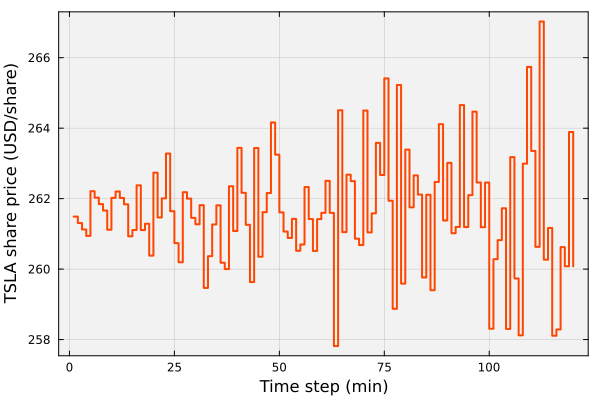

In [27]:
let
    plot(samples_share_price[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:orangered1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

### TODO: Sample synthetic future implied volatility trajectories
To generate synthetic short-term future implied volatility trajectories, we construct a simple model that assumes the future implied volatility is [Normally distributed around the initial implied volatility level](https://en.wikipedia.org/wiki/Normal_distribution):
$$
\begin{equation}
\sigma_{j} \sim \mathcal{N}(\sigma_{\circ},\sigma_{\sigma})\quad\forall{j}
\end{equation}
$$
where $\sigma_{j}$ denotes the implied volatility level during period $j$, $\sigma_{\circ}$ denotes the implied volatility at the start of the trading session (assumed constant for `number_of_trading_periods` minutes), and $\sigma_{\sigma}$ denotes the volatility of the volatility. We know $\sigma_{\circ}$ from the contract details. However, we do not know $\sigma_{\sigma}$ and must estimate it from somewhere.

* __Strategy (hack)__: We would ideally estimate $\sigma_{\sigma}$ by using 1-minute aggregate measurements of the option and share prices (or the implied volatility directly) for this specific `TSLA` contract. However, this data is typically not readily available. Therefore, we will approximate the volatility of the `TSLA` option implied volatility using the [volatility of the VIX index](https://www.cboe.com/tradable_products/vix/) multiplied by the $\beta_{\text{TSLA}}$:
$$
\begin{equation}
\sigma_{\sigma}\simeq\beta_{\text{TSLA}}\cdot\sigma_{\text{VIX}}
\end{equation}
$$
To estimate $\sigma_{\sigma}$, we first compute the growth rates, which are the time-scaled return of the [CBOE VIX index](https://www.cboe.com/tradable_products/vix/) using a [log_growth_matrix function implementation](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). Next, we will compute the standard deviation of these values using [the `std(...)` function provided by the Statistics.jl package in Julia](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.std), i.e., the $\sigma_{\text{VIX}}$ value. This process will initially provide us with an estimate of the volatility of the volatility of the S&P500, and not of `TSLA`. To _approximate_ the specific value of $\sigma_{\sigma}$ for `TSLA,` we will multiply the earlier value by $\beta_{\text{TSLA}}$, and save this final value in the `vol_of_vol::Float64` variable.

In [29]:
vol_of_vol = log_growth_matrix(volatility_data_df, Δt = 1.0, keycol=:close) |> x-> std(x) |> x-> β*x; # keep on 1 x min scale

Now that we have a $\sigma_{\sigma}$ estimate for `TSLA,` we can generate synthetic implied volatility sequences for our hedging calculations. First, we construct the $\mathcal{N}(\sigma_{\circ},\sigma_{\sigma})$ using the [Normal type exported by the Distributions.jl package](https://github.com/JuliaStats/Distributions.jl), we then sample this model using the [specialized `rand(...)` function exported by Distributions.jl](https://juliastats.org/Distributions.jl/stable/univariate/#Base.rand-Tuple{AbstractRNG,%20UnivariateDistribution}). 
* We store the random implied volatility samples in the `number_of_trading_periods`$\times$`number_of_samples` array `samples_IV::Array{Float64,2}`, where we set the value on the first row (for all samples) to the initial implied volatility value `IVₒ`

In [31]:
samples_IV = Normal(IVₒ,vol_of_vol) |> d -> rand(d, number_of_trading_periods, number_of_samples)
samples_IV[1,1:end] .= IVₒ;

#### Visualize implied volatility trajectory
`Unhide` the code block below to view how we generated a plot of the implied volatility for a put option on `TSLA` with `DTE = 60 days` until expiration, where the initial share price is `Sₒ = 261.49 USD per share`. The data shown is for the `sample_synthetic_index` chosen randomly.
* __Summary__: The implied volatility model generates a random sequence of implied volatility over a trading window of length `number_of_trading_periods.` There are some potential issues with this model. For instance, $\sigma_{o}$ and $\sigma_{\sigma}$ may not be stationary, meaning that the average could shift or there could be sudden changes in implied volatility due to external events such as earnings reports or geopolitical events. We ignore these types of events, but more sophisticated models are possible.

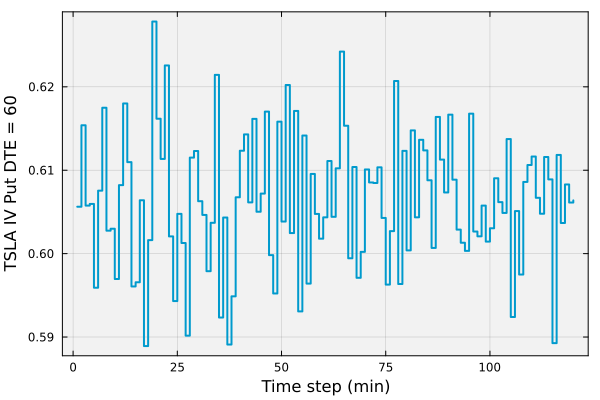

In [33]:
let
    plot(samples_IV[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:deepskyblue3, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA IV Put DTE = 60", fontsize=18)
end

## Task 2: Construct a dynamically hedged position on a TSLA put
In this task, we'll dynamically compute the number of shares in the hedged position that are required to exactly maintain the value of the position.
A delta-neutral hedge on the long `TSLA` put contract involves buying and selling `TSLA` shares to balance the delta, i.e., the sensitivity of the combined options and equity position to changes in `TSLA` share price. For a hedged position, during the trading period $t\rightarrow{t+dt}$, changes in the options premium are balanced by a gain or loss in the value associated with a counter-asset position (_hedge constraint_ written per contract):
$$
\begin{equation}
100\cdot{d\mathcal{P}} + \mathcal{H} = 0\,\Bigr|_{t\rightarrow{t+dt}}
\end{equation}
$$
where $\mathcal{H}$ denotes the hedge value of the counter asset. Let's equity, e.g., shares of `TSLA` as the counter asset. In this case, we can re-write $\mathcal{H}$ as the difference in the value of an equity position at $t\rightarrow{t+dt}$:
$$
\begin{equation}
\mathcal{H} = n_{t+dt}\cdot{S}_{t+dt} - n_{t}\cdot{S}_{t}
\end{equation}
$$
which we can substitute into the _hedge constraint_ to give the number of shares needed at the end of the interval to offset changes in the options premium during the interval:
$$
\begin{equation}
n_{t+dt} = n_{t}\cdot\left(\frac{S_{t}}{S_{t+dt}}\right) - \frac{100}{S_{t+dt}}\cdot{d\mathcal{P}}
\end{equation}
$$

### Assumptions
Let's make a few assumptions (which we'll revisit later) about the share balance shown above during our initial implementation: 
* __Assumption 1__: We know _exact_ values for the share price $S_{t+dt}$ and the option premium $\mathcal{P}_{t+dt}$ at the end of the interval. This allows us to approximate the change in premium over the interval as $d\mathcal{P}\approx\mathcal{P}_{t+dt} - \mathcal{P}_{t}$, and to compute a value for $n_{t+dt}$.
* __Assumption 2__: There is _no friction_ involving the purchase of the $n_{t+dt}$ shares, i.e., we purchase the shares instantly, our order gets filled at $S_{t+dt}$, and there are no transaction costs associated with purchasing the shares.

These assumptions will enable us to calculate an idealized perfect hedge, which, while not feasible, can be used as a benchmark to assess the performance of any actual implementation.

### TODO: Build a put contract model
To begin, let's build a [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). 
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}) takes two arguments: first, we pass in the type that we want to build, and second we pass data required to initialize the [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) packaged in a [Julia NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). We store the contract model in the `put_option_model::MyAmericanPutContractModel` variable.

In [36]:
put_option_model = build(MyAmericanPutContractModel, (
    K = example_put_contract["details"]["strike_price"], # random contract
    premium = example_put_contract["last_quote"]["midpoint"], # use last quote midpoint price from the random contract
    DTE = T,
    sense = 1,
    copy = 1,
    IV = example_put_contract["implied_volatility"], # use observed IV value
));

### TODO: Compute the Greek values for the sample TSLA put option
In the `project` for this module, we'll make heavy use of [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw), and particularly, the
[delta](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta), 
[theta](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.theta),
[vega](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.vega) and 
[gamma](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.gamma) functions. 
Now that we have the contract model, we can compute [the Greek values](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) and store them in the `long_greek_dictionary.` The `long_greek_dictionary` variable is a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries), where the key is the [Julia Union type](https://docs.julialang.org/en/v1/base/base/#Core.Union) between the contract model types, i.e.,  [MyAmericanPutContractModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) $\cup$ [MyAmericanCallContractModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanCallContractModel) and the values are [NamedTuples](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding the various Greek values

In [38]:
long_greek_dictionary = Dict{Union{MyAmericanPutContractModel,MyAmericanCallContractModel}, NamedTuple}();

Compute and store the Greek values for the put option in the `long_greek_dictionary.` This dictionary is keyed by the `put_option_model` instance and holds a [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) as its value. To do this, we call the [delta](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta), 
[theta](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.theta),
[vega](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.vega),
[rho](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.delta) and 
[gamma](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.gamma) functions, with the appropriate contract model, i.e., the `put_option_model` variable for the put contract, and the various other lattice parameters, we then store each value using a named key:

In [40]:
long_greek_dictionary[put_option_model] = (
    delta_value = delta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    theta_value = theta(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    vega_value = vega(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate),
    gamma_value = gamma(put_option_model, h = h,  T = put_option_model.DTE, 
        σ = put_option_model.IV, Sₒ = Sₒ, μ = risk_free_rate));

#### Check: Check the Greeks calculation for the TSLA option
Let's check our Greek implementation against the values from the market data for the `TSLA` option. Excluding [gamma](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.gamma), we expect that our computed and the observed values of [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) will be less $\pm$5% different. 
* For delta, theta, and vega, grab the values from the `long_greek_dictionary` and then calculate the absolute relative percentage difference between the computed and observed values. We use the [Julia @assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check that the absolute relative percentage difference is less than `5%.` If this assertion fails, [an AssertionError is thrown](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError)

In [42]:
computed_delta_value = long_greek_dictionary[put_option_model].delta_value; # we can use the . because teh dictionary returns a NamedTuple
(computed_delta_value - example_put_contract["greeks"]["delta"])/(example_put_contract["greeks"]["delta"]) |>
    error -> @assert 100*abs(error) ≤ 5.0

In [43]:
computed_theta_value = long_greek_dictionary[put_option_model].theta_value;
(computed_theta_value - example_put_contract["greeks"]["theta"])/(example_put_contract["greeks"]["theta"]) |>
    error -> @assert 100*abs(error) ≤ 5.0

In [44]:
computed_vega_value = long_greek_dictionary[put_option_model].vega_value;
(computed_vega_value - example_put_contract["greeks"]["vega"])/(example_put_contract["greeks"]["vega"]) |>
    error -> @assert 100*abs(error) ≤ 5.0

### TODO: Simulate a Dynamic Equity Hedge Assuming Perfect Information 
We are ready to simulate the hedge on the `TSLA` put option using a single `for-loop` over the `number_of_trading_periods` minutes. To store the simulation data, we initialize the `perfect_hedge_simulation::Dict{Int64, NamedTuple}` dictionary, where the keys hold the period index and the values are [Julia NamedTuple instances](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). We also initialize the initial number of shares in the hedge `nₒ::Float64` and the initial option premium value `Pₒ::Float64.` Then, for each iteration of the loop, we:
* We compute (or access) the data needed to compute the option premium in time period $i$. First, we reduce the duration of the contract by one trading period, i.e., one minute, and store this in the `Tᵢ::Float64` variable. Then we access the new share price `Sᵢ::Float64` and implied volatility `IVᵢ::Float64` from the `samples_share_price` and `samples_IV` arrays.
* Next, we compute the option premium in interval $i$ using a [binomial tree methodology](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#Binomial-pricing-model) and save this value in the `Pᵢ::Float64` variable. This calculation first builds a [MyAdjacencyBasedCRREquityPriceTree instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAdjacencyBasedCRREquityPriceTree), fills in the tree using the [`populate(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.populate-Tuple{MyAdjacencyBasedCRREquityPriceTree}) and computes the new contract premium using the [`premium(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.premium).
* We then compute the new value for the number of shares `nᵢ::Float64` in the hedge, as well as some other data associated with the trading period. We store this information in the `perfect_hedge_simulation` dictionary and update the number of shares, premium, and share price for the next interval.

In [46]:
perfect_hedge_simulation = Dict{Int64,NamedTuple}();
nₒ, Pₒ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium;
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE
Tₒ = put_option_model.DTE;
for i ∈ 1:(number_of_trading_periods - 1)

    # get data for this trading period
    Tᵢ = Tₒ - (i)*Δt;
    Sᵢ = samples_share_price[i+1, sample_synthetic_index]; # note: i = 1 is the *current* time point, i + 1 is the *next* value (end of the period)
    IVᵢ = samples_IV[i+1, sample_synthetic_index];
    
    # compute the premium using CRR -
    Pᵢ = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = risk_free_rate, T = Tᵢ, σ = IVᵢ)) |> (x-> populate(x, Sₒ = Sᵢ, h = h)) |> mᵢ -> premium(put_option_model, mᵢ)   
    
    # compute the delta hedge (number of shares we need to be long in the counter asset)
    nᵢ = nₒ*(Sₒ/Sᵢ) - 100*(Pᵢ - Pₒ)/Sᵢ; # new shares
    residual = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ) # residual
    LS = (nᵢ*Sᵢ - nₒ*Sₒ) # long share value
    DP = 100*(Pᵢ - Pₒ) # change in premium
    
    # data capture -
    perfect_hedge_simulation[i] = (shares = nₒ, shares_next = nᵢ, price = Sₒ, price_next = Sᵢ, IV = IVᵢ, premium = Pₒ, 
        premium_next = Pᵢ, hedge = residual, long_shares_diff = LS, long_premium_diff = DP)

    nₒ = nᵢ; # update the shares at the start of the next interval
    Pₒ = Pᵢ; # update the premium at the start of the next interval
    Sₒ = Sᵢ; # update the share price at the start of the next interval
end

### Visualize the hedge trajectory
`Unihide` the code block below to see how we plotted the $n_{t+dt}$ trajectory for the selected `TSLA` put option.
* __Summary__: We initially start the simulation with $100\times|\Delta_{p}|$ shares of `TSLA,` i.e., we use the equivalent share meaning of delta to perfectly balance the long and short positions in `TSLA` represented by the long put option (short shares) and the long equity position. As time moves in 1-minute increments, we buy or sell `TSLA` shares to perfectly compensate for changes in the options premium. The size of the counter-share position varies between approximately 42 shares and 44 shares, or about `5.0%` over the 120 simulation period for the chosen options contract. However, these values could change significantly if a different put option contract is chosen.

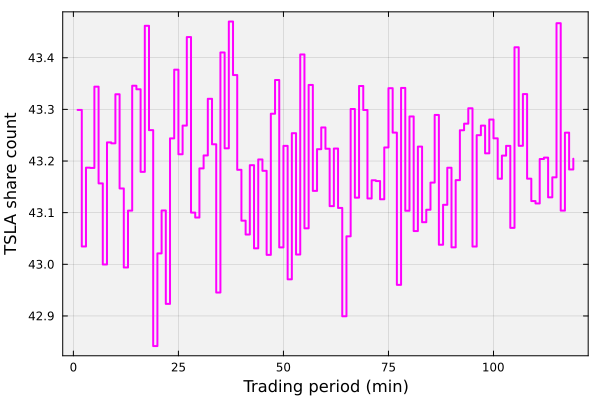

In [48]:
let
    local_data_array = Array{Float64,2}(undef, number_of_trading_periods - 1, 2);
    for i ∈ 1:(number_of_trading_periods - 1)
        local_data_array[i,1] = i;
        local_data_array[i,2] = perfect_hedge_simulation[i].shares;
    end

    plot(local_data_array[:,1], local_data_array[:,2], linetype=:steppost, label="", lw=2, c=:magenta1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period (min)", fontsize=18)
    ylabel!("TSLA share count", fontsize=18)
end

### Build profit, loss, and cost table for the hedged TSLA position
`Unhide` the code block below to see how we constructed a table holding the hedging data using [a DataFrame](https://github.com/JuliaData/DataFrames.jl) in combination with [the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl). We show hedging data for the first 20 minutes of the simulation.
* __Summary__: For each period $i$, the change in the options premium ($dP_{i}$) is offset by the hedge value ($H_{i}$). This is achieved by buying or selling `TSLA` shares at $S_{i}$, where $dn_{i}$ represents the change in the number of `TSLA` shares held in the hedge, and $S_{i}\cdot{dn_{i}}$ represents the proceeds (`+` values) or costs (`-` values) incurred by rebalancing the hedge during the period. The cumulative value of the rebalancing is shown in the `Σ` column. The hedge is considered perfect, assumed to have perfect information, and the hedged liquidation value (`HLV`) is equal to the cost of the initial number of shares and the premium of the option, which in this case was `13692.2 USD`. The perfect hedge ensures that each period has zero net hedged liquidation value (`NHLV`). Lastly, the cumulative profit and loss (`ΣPLH`) column indicates a cash flow from rebalancing the equity hedge.

In [50]:
let
    n̄, P̄, S̄ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium, example_put_contract["underlying_asset"]["price"];
    C̄ = (n̄*S̄ + 100*P̄); # cost associated with the position
    
    tmp = DataFrame();
    tmp_cost_sum = Array{Float64,1}();
    for i ∈ 1:number_of_trading_periods-1

        data_tuple = perfect_hedge_simulation[i];
    
        # current -
        nₒ = data_tuple.shares;
        Sₒ = data_tuple.price;
        Pₒ = data_tuple.premium;
    
        # next -
        nᵢ = data_tuple.shares_next;
        Sᵢ = data_tuple.price_next;
        Pᵢ = data_tuple.premium_next;
    
        # compute H -
        residual = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ);
        
        # What is the cost of maintaining the hedge?
        dnᵢ = (nᵢ - nₒ); # diff in shares
        Cᵢ = -sign(dnᵢ)*abs(dnᵢ)*Sᵢ
        push!(tmp_cost_sum,Cᵢ);

        # package -
        row_df = (
            i = (i),
            Hᵢ = (nᵢ*Sᵢ - nₒ*Sₒ),
            dPᵢ = 100*(Pᵢ - Pₒ),
            Sᵢ = Sᵢ,
            dnᵢ = (nᵢ - nₒ),
            Sᵢdnᵢ = -Sᵢ*(nᵢ - nₒ),
            Σ = sum(tmp_cost_sum),
            HLV = (100*Pᵢ + nᵢ*Sᵢ),
            NHLV = abs(round((100*Pᵢ + nᵢ*Sᵢ) - C̄)),
            ΣPLH = (100*Pᵢ + nᵢ*Sᵢ) - C̄ + sum(tmp_cost_sum)
        );
        push!(tmp, row_df)
    end
    pretty_table(tmp[1:20,:])
end

┌───────┬─────────┬─────────┬─────────┬──────────────┬──────────┬──────────┬─────────┬─────────┬──────────┐
│     i │      Hᵢ │     dPᵢ │      Sᵢ │          dnᵢ │    Sᵢdnᵢ │        Σ │     HLV │    NHLV │     ΣPLH │
│ Int64 │ Float64 │ Float64 │ Float64 │      Float64 │  Float64 │  Float64 │ Float64 │ Float64 │  Float64 │
├───────┼─────────┼─────────┼─────────┼──────────────┼──────────┼──────────┼─────────┼─────────┼──────────┤
│     1 │   -77.0 │    77.0 │ 261.308 │    -0.264464 │  69.1064 │  69.1064 │ 13692.2 │     0.0 │  69.1064 │
│     2 │    32.0 │   -32.0 │ 261.125 │      0.15257 │ -39.8399 │  29.2664 │ 13692.2 │     0.0 │  29.2664 │
│     3 │    -8.0 │     8.0 │ 260.943 │ -0.000527895 │ 0.137751 │  29.4042 │ 13692.2 │     0.0 │  29.4042 │
│     4 │    96.0 │   -96.0 │  262.21 │     0.157425 │ -41.2784 │ -11.8742 │ 13692.2 │     0.0 │ -11.8742 │
│     5 │   -57.0 │    57.0 │ 262.028 │    -0.187295 │  49.0764 │  37.2022 │ 13692.2 │     0.0 │  37.2022 │
│     6 │   -49.0 │    49.0 

## Task 3: Save the system state to a file
We'll use some of the calculations from this example in the project for this module, so let's save this data as a [binary file encoded in the HDF5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) using the [methods exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl). First, let's specify a path and file name for the data file in the `path_to_save_file::String` variable:

In [52]:
path_to_save_file = joinpath(_PATH_TO_DATA, "CHEME-134-M4-WorkedExample-State.jld2");

Then, let's write data to the `path_to_save_file` using [the `save(...)` function exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl):

In [54]:
save(path_to_save_file, Dict(
        "put_option_model" => put_option_model,
        "samples_share_price" => samples_share_price,
        "samples_IV" => samples_IV,
        "sample_synthetic_index" => sample_synthetic_index,
        "example_put_contract" => example_put_contract,
        "risk_free_rate" => risk_free_rate,
        "h" => h,
        "DTE" => DTE,
        "T" => T,
        "number_of_trading_periods" => number_of_trading_periods,
        "β" => β,
        "number_of_samples" => number_of_samples,
        "Δt" => Δt,
        "perfect_hedge_simulation_example" => perfect_hedge_simulation,
));

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.